In [4]:
import numba
from numba import njit , prange
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import time
from joblib import Parallel, delayed
from operator import mod
import hints



path='/Users/....'



In [ ]:
@njit
def MY_EM_SDE(N,F,G,Ksi,dt,nsteps,x0):
    x = np.zeros((N,nsteps))
    dw=np.random.normal(0, 1, (N,nsteps)) * np.sqrt(dt)
    x[:,0]=x0
    for i in range(nsteps - 1):
        # x[:,i + 1] = x[:,i] + F(x[:,i],i*dt)*dt +  np.dot(G(x[:,i],i*dt) , dw[:,i]) + Ksi(x[:,i],i*dt) 
        x[:,i + 1] = x[:,i] + F(x[:,i],i*dt)*dt + np.dot(np.ascontiguousarray(G(x[:,i],i*dt)), np.ascontiguousarray(dw[:,i])) + Ksi(x[:,i],i*dt)
    return x  

@njit
def L96F(x,t):
    N=len(x)
    Fcoef = 1
    F = np.zeros(N)
    for i in range(N):
        F[i] = (x[(i+1) % N] - x[i-2]) * x[i-1] - x[i] + Fcoef
    return F

@njit
def L96G(x, t):
    N=len(x)
    G=np.zeros((N,N))
    for i in range(N):
        G[i,i] = 0.02 + 0*x[i]
    return G

@njit
def L96Ksi(x, t):
    N=len(x)
    KKSSII=np.zeros(N)
    return KKSSII

@njit(parallel=True)
def calcputime():
    nansa=20
    tlist=[1,2,5,10,20,50,100,200,500,1000,2000,5000,10000]  # 
    dimenlist=[2,3,4,5,6,7,8,9,10]
    mlist=[2,3,4,5]
    dt=0.001

    times=np.zeros((len(mlist), len(dimenlist), len(tlist), nansa))
    for M in mlist:
        for N in dimenlist:
            for t in tlist:
                print("M=", M,"N=", N,"t=", t)
                for ansa in range(nansa):
                    x0=np.ones(N)
                    x = MY_EM_SDE(N,L96F,L96G,L96Ksi,dt,int(t/dt),x0)
                    start=time.perf_counter();         calulator = hints.kmcc(ts_array=np.swapaxes(x,0,1), dt=dt, interaction_order=M, estimation_mode='drift');         Dcoeffs = calulator.get_coefficients();         finish=time.perf_counter() 
                    times[mlist.index(M), dimenlist.index(N), tlist.index(t), ansa] = finish-start

    np.save(path+'FinalTimes.npy', times)


In [ ]:
# calcputime()

times = np.load("FinalTimes.npy")

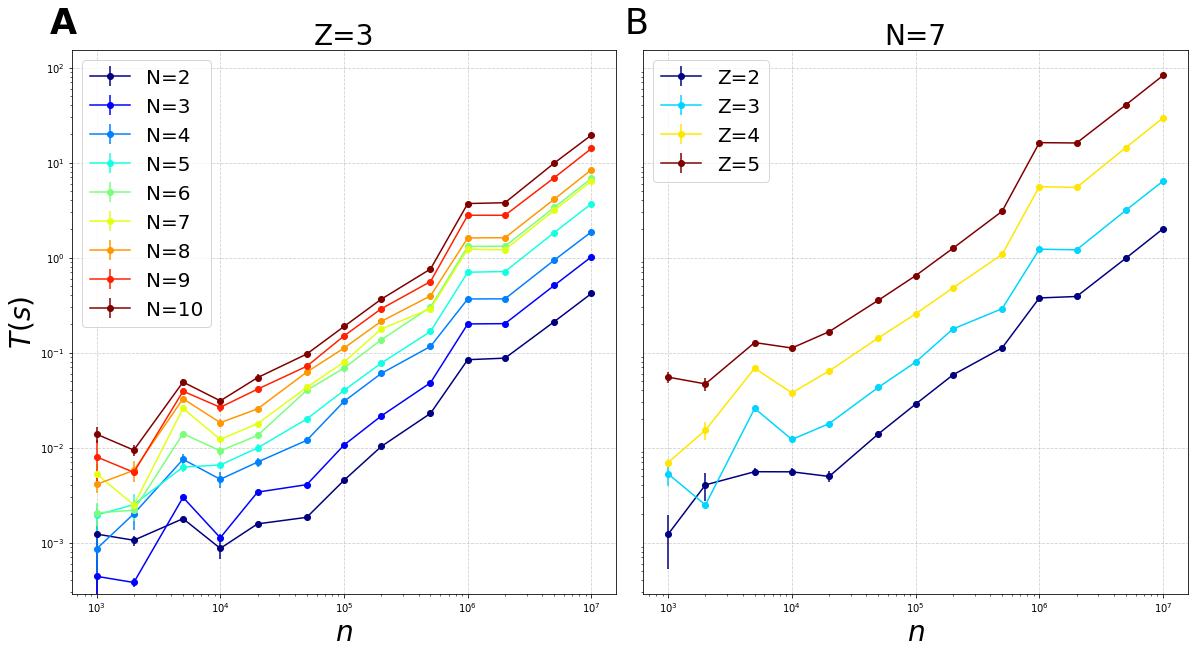

In [6]:


dt=0.001
panel_label_pos=[-0.1,1.1]
fig = plt.figure(figsize=(20, 10))
main_gs = gridspec.GridSpec(1, 2, hspace=0.4, wspace=0.05)
nansa=20
tlist=[1,2,5,10,20,50,100,200,500,1000,2000,5000,10000] 

# Panel A
####################################################################################################################################
cmap = plt.get_cmap('jet', 9) 

ax1 = fig.add_subplot(main_gs[0, 0])  
for i in range(9):
    ax1.errorbar(np.array(tlist)/dt, np.mean(times[1,i,:,:], axis=1), yerr=np.std(times[1,i,:,:], axis=1)/np.sqrt(nansa), label=f"N={i+2}", fmt='o-', color = cmap(i / 9))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$n$', fontsize=28)
ax1.set_ylabel(r'$T(s)$', fontsize=28)
ax1.set_title("Z=3", fontsize=28)
ax1.legend(loc="upper left", fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.text(panel_label_pos[0]+0.11, panel_label_pos[1]-0.02, 'A', transform=ax1.transAxes, fontsize=35,  va='top', ha='right', fontweight='bold')  


# Panel B
####################################################################################################################################
ax2 = fig.add_subplot(main_gs[0, 1])  
cmap = plt.get_cmap('jet', 4) 
for i in range(4):
    ax2.errorbar(np.array(tlist)/dt, np.mean(times[i,5,:,:], axis=1), yerr=np.std(times[i,5,:,:], axis=1)/np.sqrt(nansa), label=f"Z={i+2}", fmt='o-', color = cmap(i / 4))
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$n$', fontsize=28)
# ax2.set_ylabel(r'$T(s)$', fontsize=14)
ax2.set_title("N=7", fontsize=28)
ax2.legend(loc="upper left", fontsize=20)
# ax2.set_yticks([])
ax2.tick_params(axis='y', colors='none')
ax2.grid(True, linestyle='--', alpha=0.6)

ylim = ax2.get_ylim()
ax1.set_ylim(ylim)

ax2.text(panel_label_pos[0]+1.16, panel_label_pos[1]-0.02, 'B', transform=ax1.transAxes, fontsize=35,  va='top', ha='right')  
plt.show()